# Sequence alginment training data generation + analysis
This notebook file consists of the required functions and processes required to generate model training data from a genomic sequence string index file. Its assumed that the suffix array, BWT and occurance array are already computed. Note the only column required for training data generation is the suffix array and orgignal reference location (org_location).

## Contents:
* [Importing indexed sequence string data](#first-bullet)
* [Adding string variation](#second-bullet)
* [Reverse complement of sequence strings](#third-bullet)
* [Runlength encoding](#forth-bullet)
* [Binary encoding](#fith-bullet)
* [Feature analysis](#sixth-bullet)


## Importing indexed sequence string <a class="anchor" id="first-bullet"></a>

In [24]:
import pandas as pd

sequence = pd.read_csv('P1_dataset/indexed_reference.csv')
seed_set = pd.DataFrame({'org_location':sequence['org_location'],
                            'seed':sequence['seed'],})

sequence.head(3)

,org_location,suffix_array,first,BWT,$,A,C,G,T,seed
0,0,$TTTTCGGAGGTTCTCTAACTAGTATGGATTGCGGTGTCTTCACTG...,$,G,0,0,0,1,0,$TTTTCGGAGGTTCTCTAACTAGTATGG
1,8071,AAAAAAAGATATCAGGAACTCTCCTCCTCAGCAGTCTGGTCTATGG...,A,G,0,0,0,2,0,AAAAAAAGATATCAGGAACTCTCCTCCT
2,8754,AAAAAACTCTGGCTGGACGCAAGCCGTAACACCCGTGTCACTTCAT...,A,T,0,0,0,2,1,AAAAAACTCTGGCTGGACGCAAGCCGTA


## Reverse complament <a class="anchor" id="third-bullet"></a>
The reverse complement of a DNA sequence is formed by reversing the letters, interchanging A and T and interchanging C and G. Thus the reverse complement of ACCTGAG is CTCAGGT. The complement is the Watson-Crick counterpart of the DNA string -> This counterpart is called its complementary nucleotide. This gets into double stranded analysis which is prob not a road we want to go down. However 

- Original sequence: ACGTATAGGCTGACACGTAGAGATGGATGACCATAG
- Reverse sequence: GATACCAGTAGGTAGAGATGCACAGTCGGATATGCA
- Complement sequence: TGCATATCCGACTGTGCATCTCTACCTACTGGTATC
- Reverse complement: CTATGGTCATCCATCTCTACGTGTCAGCCTATACGT -> results in a representation of its partner strand

http://genewarrior.com/docs/exp_revcomp.jsp#:~:text=The%20complementary%20sequence%20is%20thus,to%20its%205%E2%80%B2%2Dend.

This should prob be before runlength encoding


In [25]:
""" Reverse complament using biopython """

from Bio.Seq import Seq

def reverse_complement(sequence_set):
    sequence_strings = sequence['seed']
    
    rc_strings = []
    clean_rc_strings = []
    for string in sequence_strings:
        s_seq = Seq(string)
        rc_string = s_seq.reverse_complement()
        rc_strings.append(rc_string)
        
    for row in rc_strings:
        new_string = ''.join(row)
        clean_rc_strings.append(new_string)

    sequence['rc_seeds'] = clean_rc_strings
    return sequence_set

df_var_complete = reverse_complement(sequence)

In [26]:
df_var_complete

,org_location,suffix_array,first,BWT,$,A,C,G,T,seed,rc_seeds
0,0,$TTTTCGGAGGTTCTCTAACTAGTATGGATTGCGGTGTCTTCACTG...,$,G,0,0,0,1,0,$TTTTCGGAGGTTCTCTAACTAGTATGG,CCATACTAGTTAGAGAACCTCCGAAAA$
1,8071,AAAAAAAGATATCAGGAACTCTCCTCCTCAGCAGTCTGGTCTATGG...,A,G,0,0,0,2,0,AAAAAAAGATATCAGGAACTCTCCTCCT,AGGAGGAGAGTTCCTGATATCTTTTTTT
2,8754,AAAAAACTCTGGCTGGACGCAAGCCGTAACACCCGTGTCACTTCAT...,A,T,0,0,0,2,1,AAAAAACTCTGGCTGGACGCAAGCCGTA,TACGGCTTGCGTCCAGCCAGAGTTTTTT
3,8072,AAAAAAGATATCAGGAACTCTCCTCCTCAGCAGTCTGGTCTATGGA...,A,A,0,1,0,2,1,AAAAAAGATATCAGGAACTCTCCTCCTC,GAGGAGGAGAGTTCCTGATATCTTTTTT
4,565,AAAAAAGCACGTGGTGGCGCCCACCGACTGTTCCCAAACTGTAGCT...,A,C,0,1,1,2,1,AAAAAAGCACGTGGTGGCGCCCACCGAC,GTCGGTGGGCGCCACCACGTGCTTTTTT
...,...,...,...,...,...,...,...,...,...,...,...
9996,9042,TTTTTTATCTAAAGACGATGAGAGGAGTATTCGTCAGACCACATAG...,T,A,1,2416,2557,2560,2463,TTTTTTATCTAAAGACGATGAGAGGAGT,ACTCCTCTCATCGTCTTTAGATAAAAAA
9997,7100,TTTTTTCCTTGGTCCTCGAGAAGAGGAGACGTCAGTCCAGATATCT...,T,T,1,2416,2557,2560,2464,TTTTTTCCTTGGTCCTCGAGAAGAGGAG,CTCCTCTTCTCGAGGACCAAGGAAAAAA
9998,7471,TTTTTTGTCCTTTTATCCGCTCACTTAGAAAAGAGACAGATAGCTT...,T,T,1,2416,2557,2560,2465,TTTTTTGTCCTTTTATCCGCTCACTTAG,CTAAGTGAGCGGATAAAAGGACAAAAAA
9999,7099,TTTTTTTCCTTGGTCCTCGAGAAGAGGAGACGTCAGTCCAGATATC...,T,C,1,2416,2558,2560,2465,TTTTTTTCCTTGGTCCTCGAGAAGAGGA,TCCTCTTCTCGAGGACCAAGGAAAAAAA


## Run length encoding of sequence string varients <a class="anchor" id="forth-bullet"></a>

In [27]:
""" Run length encoding """
from collections import OrderedDict

def runLengthEncoding(input):
    dict = OrderedDict.fromkeys(input, 0)

    for ch in input:
        dict[ch] += 1
    output = ''
    characters = ''
    values = ''
    for key, value in dict.items():
        output = output + key + str(value)
        characters = characters + key
        values = values + str(value)
    # print(characters)
    # print(values)
    return output, characters, values

output = []
character = []
value = []

for seed_string in df_var_complete['seed']:
    out, char, val = runLengthEncoding(seed_string)
    output.append(out)
    character.append(char)
    value.append(val)
    
df_var_complete['runlength_output'] = output
df_var_complete['runlength_character'] = character
df_var_complete['runlength_value'] = value

del output
del character
del value

rc_output = []
rc_character = []
rc_value = []

for rc_seed_string in df_var_complete['rc_seeds']:
    rc_out, rc_char, rc_val = runLengthEncoding(rc_seed_string)
    rc_output.append(rc_out)
    rc_character.append(rc_char)
    rc_value.append(rc_val)
    
df_var_complete['runlength_rc_output'] = rc_output
df_var_complete['runlength_rc_character'] = rc_character
df_var_complete['runlength_rc_value'] = rc_value

del rc_output
del rc_character
del rc_value
    

In [28]:
#df_var = df_var.drop('total_variation', axis=1)
df_var_complete

,org_location,suffix_array,first,BWT,$,A,C,G,T,seed,rc_seeds,runlength_output,runlength_character,runlength_value,runlength_rc_output,runlength_rc_character,runlength_rc_value
0,0,$TTTTCGGAGGTTCTCTAACTAGTATGGATTGCGGTGTCTTCACTG...,$,G,0,0,0,1,0,$TTTTCGGAGGTTCTCTAACTAGTATGG,CCATACTAGTTAGAGAACCTCCGAAAA$,$1T11C4G7A5,$TCGA,111475,C7A11T5G4$1,CATG$,711541
1,8071,AAAAAAAGATATCAGGAACTCTCCTCCTCAGCAGTCTGGTCTATGG...,A,G,0,0,0,2,0,AAAAAAAGATATCAGGAACTCTCCTCCT,AGGAGGAGAGTTCCTGATATCTTTTTTT,A12G3T6C7,AGTC,12367,A6G7T12C3,AGTC,67123
2,8754,AAAAAACTCTGGCTGGACGCAAGCCGTAACACCCGTGTCACTTCAT...,A,T,0,0,0,2,1,AAAAAACTCTGGCTGGACGCAAGCCGTA,TACGGCTTGCGTCCAGCCAGAGTTTTTT,A10C7T4G7,ACTG,10747,T10A4C7G7,TACG,10477
3,8072,AAAAAAGATATCAGGAACTCTCCTCCTCAGCAGTCTGGTCTATGGA...,A,A,0,1,0,2,1,AAAAAAGATATCAGGAACTCTCCTCCTC,GAGGAGGAGAGTTCCTGATATCTTTTTT,A11G3T6C8,AGTC,11368,G8A6T11C3,GATC,86113
4,565,AAAAAAGCACGTGGTGGCGCCCACCGACTGTTCCCAAACTGTAGCT...,A,C,0,1,1,2,1,AAAAAAGCACGTGGTGGCGCCCACCGAC,GTCGGTGGGCGCCACCACGTGCTTTTTT,A9G8C9T2,AGCT,9892,G9T9C8A2,GTCA,9982
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9996,9042,TTTTTTATCTAAAGACGATGAGAGGAGTATTCGTCAGACCACATAG...,T,A,1,2416,2557,2560,2463,TTTTTTATCTAAAGACGATGAGAGGAGT,ACTCCTCTCATCGTCTTTAGATAAAAAA,T10A9C2G7,TACG,10927,A10C7T9G2,ACTG,10792
9997,7100,TTTTTTCCTTGGTCCTCGAGAAGAGGAGACGTCAGTCCAGATATCT...,T,T,1,2416,2557,2560,2464,TTTTTTCCTTGGTCCTCGAGAAGAGGAG,CTCCTCTTCTCGAGGACCAAGGAAAAAA,T10C5G8A5,TCGA,10585,C8T5G5A10,CTGA,85510
9998,7471,TTTTTTGTCCTTTTATCCGCTCACTTAGAAAAGAGACAGATAGCTT...,T,T,1,2416,2557,2560,2465,TTTTTTGTCCTTTTATCCGCTCACTTAG,CTAAGTGAGCGGATAAAAGGACAAAAAA,T15G3C7A3,TGCA,15373,C3T3A15G7,CTAG,33157
9999,7099,TTTTTTTCCTTGGTCCTCGAGAAGAGGAGACGTCAGTCCAGATATC...,T,C,1,2416,2558,2560,2465,TTTTTTTCCTTGGTCCTCGAGAAGAGGA,TCCTCTTCTCGAGGACCAAGGAAAAAAA,T11C5G7A5,TCGA,11575,T5C7G5A11,TCGA,57511


## Binarny encoding of char values 

In [29]:
## utf-8 string encoding

def encode(index):
        '''encode the data set using 2bit encoding'''
        encoded =[]
        dictionary = {'$': '0', ',':'', 'A': '00', 'C': '01', 'G': '10', 'T': '11'}

        if isinstance(index, list):
            # encode list of strings
            for i in range(len(index)):
                substring = index[i]
                transTable = substring.maketrans(dictionary)
                txt = substring.translate(transTable)
                encoded.append(txt)
        else:
            # encode single string
            transTable = index.maketrans(dictionary)
            txt = index.translate(transTable)
            encoded = txt
        return encoded

In [30]:
df_var_complete.dtypes
df_var_complete.to_csv('sequence_data_set.csv', index = False)

In [31]:
df_var_complete.head(3)

,org_location,suffix_array,first,BWT,$,A,C,G,T,seed,rc_seeds,runlength_output,runlength_character,runlength_value,runlength_rc_output,runlength_rc_character,runlength_rc_value
0,0,$TTTTCGGAGGTTCTCTAACTAGTATGGATTGCGGTGTCTTCACTG...,$,G,0,0,0,1,0,$TTTTCGGAGGTTCTCTAACTAGTATGG,CCATACTAGTTAGAGAACCTCCGAAAA$,$1T11C4G7A5,$TCGA,111475,C7A11T5G4$1,CATG$,711541
1,8071,AAAAAAAGATATCAGGAACTCTCCTCCTCAGCAGTCTGGTCTATGG...,A,G,0,0,0,2,0,AAAAAAAGATATCAGGAACTCTCCTCCT,AGGAGGAGAGTTCCTGATATCTTTTTTT,A12G3T6C7,AGTC,12367,A6G7T12C3,AGTC,67123
2,8754,AAAAAACTCTGGCTGGACGCAAGCCGTAACACCCGTGTCACTTCAT...,A,T,0,0,0,2,1,AAAAAACTCTGGCTGGACGCAAGCCGTA,TACGGCTTGCGTCCAGCCAGAGTTTTTT,A10C7T4G7,ACTG,10747,T10A4C7G7,TACG,10477


In [32]:
#org_sequence_encoded = encode(df_var_compleate['org_sequence'].tolist())
first_char = encode(df_var_complete['first'].tolist())
bwt = encode(df_var_complete['BWT'].tolist())
# char_s = encode(df_var_complete['$'].tolist())
# char_A = encode(df_var_complete['A'].tolist())
# char_C = encode(df_var_complete['C'].tolist())
# char_G = encode(df_var_complete['G'].tolist())
# char_T = encode(df_var_complete['T'].tolist())
seeds_encoded = encode(df_var_complete['seed'].tolist())
rc_seeds_encoded = encode(df_var_complete['rc_seeds'].tolist())
runlength_output_encoded = encode(df_var_complete['runlength_output'].tolist())
runlength_character_encoded = encode(df_var_complete['runlength_character'].tolist())
runlength_rc_output_encoded = encode(df_var_complete['runlength_rc_output'].tolist())
runlength_rc_character_encoded = encode(df_var_complete['runlength_rc_character'].tolist())

In [33]:
df_var_encoded = pd.DataFrame({
    "org_location":df_var_complete['org_location'],
    "first":first_char,
    "bwt":bwt,
    "$":df_var_complete['$'],
    "A":df_var_complete['A'],
    "C":df_var_complete['C'],
    "G":df_var_complete['G'],
    "T":df_var_complete['T'],
    "seeds":seeds_encoded,
    "rc_seeds":rc_seeds_encoded,
    "runlength_output":runlength_output_encoded,
    "runlength_character":runlength_character_encoded,
    "runlength_value":df_var_complete['runlength_value'],
    "runlength_rc_output":runlength_rc_output_encoded,
    "runlength_rc_character":runlength_rc_character_encoded,
    "runlength_rc_value":df_var_complete['runlength_rc_value']
})

In [34]:
df_var_encoded

,org_location,first,bwt,$,A,C,G,T,seeds,rc_seeds,runlength_output,runlength_character,runlength_value,runlength_rc_output,runlength_rc_character,runlength_rc_value
0,0,0,10,0,0,0,1,0,0111111110110100010101111011101110000011100101...,0101001100011100101111001000100000010111010110...,011111014107005,011011000,111475,017001111510401,010011100,711541
1,8071,00,10,0,0,0,2,0,0000000000000010001100110100101000000111011101...,0010100010100010001011110101111000110011011111...,0012103116017,00101101,12367,0061071112013,00101101,67123
2,8754,00,11,0,0,0,2,1,0000000000000111011110100111101000011001000010...,1100011010011111100110110101001001010010001011...,0010017114107,00011110,10747,1110004017107,11000110,10477
3,8072,00,00,0,1,0,2,1,0000000000001000110011010010100000011101110101...,1000101000101000100010111101011110001100110111...,0011103116018,00101101,11368,1080061111013,10001101,86113
4,565,00,01,0,1,1,2,1,0000000000001001000110111010111010011001010100...,1011011010111010100110010100010100011011100111...,009108019112,00100111,9892,109119018002,10110100,9982
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9996,9042,11,00,1,2416,2557,2560,2463,1111111111110011011100000010000110001110001000...,0001110101110111010011011011011111110010001100...,1110009012107,11000110,10927,0010017119102,00011110,10792
9997,7100,11,11,1,2416,2557,2560,2464,1111111111110101111110101101011101100010000010...,0111010111011111011101100010100001010000101000...,1110015108005,11011000,10585,0181151050010,01111000,85510
9998,7471,11,11,1,2416,2557,2560,2465,1111111111111011010111111111001101011001110100...,0111000010111000100110100011000000001010000100...,1115103017003,11100100,15373,0131130015107,01110010,33157
9999,7099,11,01,1,2416,2558,2560,2465,1111111111111101011111101011010111011000100000...,1101011101111101110110001010000101000010100000...,1111015107005,11011000,11575,1150171050011,11011000,57511


In [35]:
df_var_encoded = df_var_encoded.astype('float64')
#df_var_encoded = df_var_encoded.astype('int64')

In [36]:
df_var_encoded.dtypes

org_location              float64
first                     float64
bwt                       float64
$                         float64
A                         float64
C                         float64
G                         float64
T                         float64
seeds                     float64
rc_seeds                  float64
runlength_output          float64
runlength_character       float64
runlength_value           float64
runlength_rc_output       float64
runlength_rc_character    float64
runlength_rc_value        float64
dtype: object

In [37]:
#df_var_encoded.to_csv("training_data.csv", index = False)
df_var_encoded.to_csv("training_data.csv", index = False)

## Feature analysis <a class="anchor" id="fith-bullet"></a>

https://jakevdp.github.io/PythonDataScienceHandbook/05.09-principal-component-analysis.html
https://medium.com/@hongwy1128/intro-guide-to-factor-analysis-python-84dd0b0fd729

Text(0.5, 1.0, 'Training Data correlations')

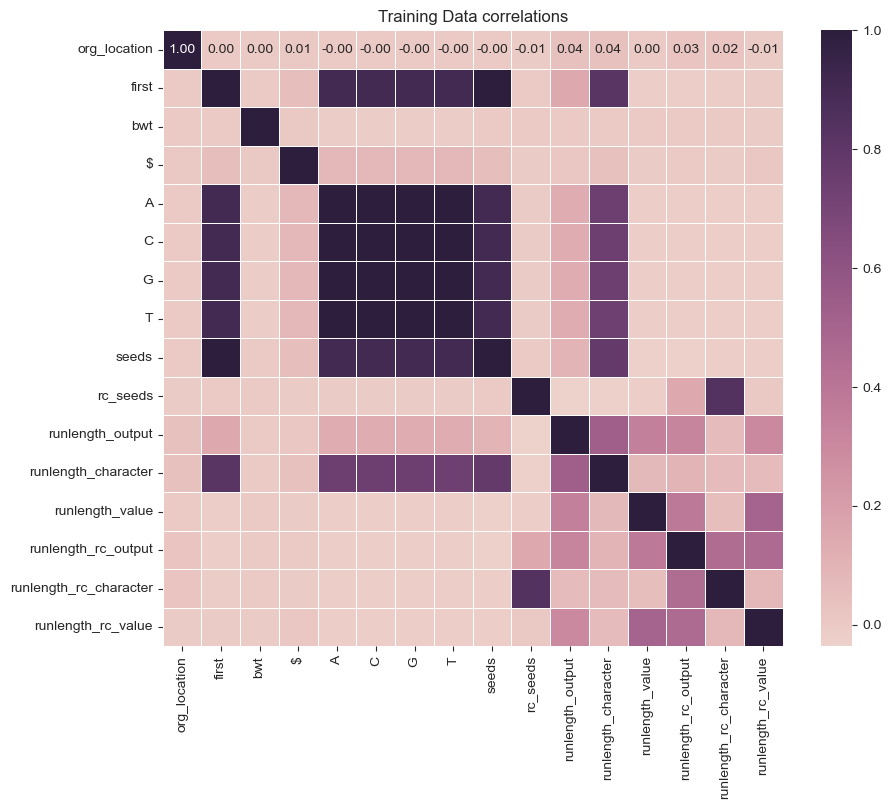

In [38]:
'''Correlation matrix '''
import seaborn as sns
import matplotlib.pyplot as plt

# Data preparation
data = df_var_encoded
corrmat = data.corr()
top_corr_features = corrmat.index

# plot heatmap
#palette = sns.color_palette("rocket_r", as_cmap=True)
palette = sns.cubehelix_palette(as_cmap=True)
g = plt.figure(figsize=(10,8))
g = sns.heatmap(data[top_corr_features].corr(),
                annot=True,
                fmt=".2f", 
                cmap=palette,
                linewidth=.5)
g.figure.savefig("training_data_corr.png")
g.set(xlabel="", ylabel="")
g.set_title('Training Data correlations')

In [39]:
corrmat

,org_location,first,bwt,$,A,C,G,T,seeds,rc_seeds,runlength_output,runlength_character,runlength_value,runlength_rc_output,runlength_rc_character,runlength_rc_value
org_location,1.000000,0.000856,0.000547,0.008085,-0.001474,-0.001502,-0.001683,-0.001602,-0.003866,-0.006871,0.037808,0.038845,0.003057,0.027529,0.023941,-0.005471
first,0.000856,1.000000,-0.002246,0.051254,0.906015,0.904443,0.905094,0.903745,0.997460,-0.002825,0.150912,0.821086,-0.016046,-0.014487,-0.009915,-0.007987
bwt,0.000547,-0.002246,1.000000,0.005275,-0.010037,-0.010087,-0.009613,-0.009758,-0.002150,-0.003712,0.000223,-0.002803,-0.003971,0.001766,-0.003256,-0.004851
$,0.008085,0.051254,0.005275,1.000000,0.080830,0.082663,0.080287,0.080697,0.051899,-0.006575,0.011740,0.040330,-0.004905,-0.000970,-0.006445,0.013642
A,-0.001474,0.906015,-0.010037,0.080830,1.000000,0.999899,0.999865,0.999851,0.906292,-0.005989,0.136511,0.742383,-0.019491,-0.014100,-0.014589,-0.013192
C,-0.001502,0.904443,-0.010087,0.082663,0.999899,1.000000,0.999786,0.999865,0.904725,-0.005863,0.136343,0.741121,-0.019615,-0.013855,-0.014344,-0.013132
G,-0.001683,0.905094,-0.009613,0.080287,0.999865,0.999786,1.000000,0.999905,0.905376,-0.005992,0.136123,0.741464,-0.019748,-0.014075,-0.014637,-0.013468
T,-0.001602,0.903745,-0.009758,0.080697,0.999851,0.999865,0.999905,1.000000,0.904041,-0.005937,0.135975,0.740334,-0.019606,-0.014033,-0.014553,-0.013423
seeds,-0.003866,0.997460,-0.002150,0.051899,0.906292,0.904725,0.905376,0.904041,1.000000,0.000040,0.100235,0.779039,-0.027075,-0.028243,-0.018870,-0.016183
rc_seeds,-0.006871,-0.002825,-0.003712,-0.006575,-0.005989,-0.005863,-0.005992,-0.005937,0.000040,1.000000,-0.036396,-0.025077,-0.016527,0.152369,0.840071,0.006454


### EFA or PCA?
EFA is a statistical method used to uncover the underlying structure of a set of variables. It aims to identify the latent factors that explain the correlations among observed variables. EFA assumes that observed variables are influenced by underlying factors that are not directly measured. It helps in understanding the relationships between variables and identifying patterns in the data without preconceived notions about the structure of the factors Park (2002)Tipping & Bishop, 1999).

On the other hand, PCA is a dimensionality reduction technique that transforms the original variables into a new set of orthogonal variables called principal components. PCA aims to capture the maximum amount of variance in the data with a smaller number of components. Unlike EFA, PCA does not directly identify latent factors but focuses on summarizing the data by retaining as much variance as possible in a smaller number of components (Tipping & Bishop, 1999).

Therefore: 
* We dont care about underlying latient classes, as there is an understanding on where these values comefrom and nothing to suggest they are being driven by some underlying/indirect factor 
* Therefore -> we should use PCA

## PCA of dataset

In [40]:
''' This should be a fig toward the end of the data subsection '''
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import pandas as pd
from sklearn.pipeline import Pipeline

# Data load
data = df_var_encoded
X = data.drop(['org_location'], axis=1)
y = data['org_location']

# PCA & standardisation 
pca = PCA()  # Set the number of components to 8
pipe = Pipeline([('scaler', StandardScaler()), ('pca', pca)])
X_pca = pipe.fit_transform(X)

# Tidy output 
pca_df = pd.DataFrame(X_pca, columns=[f"PC{i+1}" for i in range(15)])
pca_df['org_location'] = y


In [41]:
pca_df

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,org_location
0,-2.829855,11.905820,6.636491,0.998953,0.011146,-3.529913,4.266591,-7.456796,0.915523,0.424669,-0.314946,0.037486,-0.003002,0.152469,-0.032672,0.0
1,-3.822304,-0.525193,1.382777,0.714731,-0.528471,0.060573,0.441538,-0.778966,0.691525,-0.043564,0.072511,0.028175,0.030676,0.002970,-0.003820,8071.0
2,-3.841166,0.570793,-1.354938,0.857931,-0.725121,0.626942,0.061719,-0.024821,0.610748,-0.273782,-0.022452,0.027960,0.031397,0.002539,-0.002911,8754.0
3,-3.821408,1.124368,-0.663730,-0.811980,0.747834,0.074955,0.149759,-1.159011,0.670734,-0.129683,0.004072,0.027114,0.030642,0.003143,-0.002381,8072.0
4,-3.830111,0.233441,-1.190604,-0.702320,0.517982,0.771254,-0.154817,-0.153997,0.634902,-0.184385,0.062669,0.028463,0.030854,0.003553,-0.003249,565.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9996,4.503837,-1.415604,0.959546,12.411909,16.958352,2.674291,0.233763,0.591676,0.332538,-0.038523,0.005961,-0.000428,0.001644,0.000313,0.000645,9042.0
9997,4.503218,-0.581489,1.194431,14.159355,15.681730,1.953180,0.211923,-0.572082,0.324011,0.091833,0.020378,-0.000447,0.002484,-0.000040,0.001626,7100.0
9998,4.504445,-1.016900,0.900365,14.131357,15.613947,2.378767,0.125249,0.277957,0.320076,0.012217,-0.004442,-0.000420,0.002922,0.001891,0.001917,7471.0
9999,4.500247,0.655218,-1.133467,12.608078,16.897148,2.357077,-0.130303,-0.213776,0.291629,-0.074501,-0.062964,-0.000750,0.003651,0.000526,0.001563,7099.0


In [42]:
pca_df = pca_df.drop(['org_location','PC10','PC11','PC12','PC13','PC14','PC15','PC6','PC7','PC8','PC9'], axis=1)
pca_df_melt = pca_df.melt(var_name='PC', value_name='loadings')
pca_df_melt
pca_df_melt_sample = pca_df_melt.sample(n=500)
pca_df_melt_sample= pca_df_melt_sample.sort_values(by='PC')

C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating

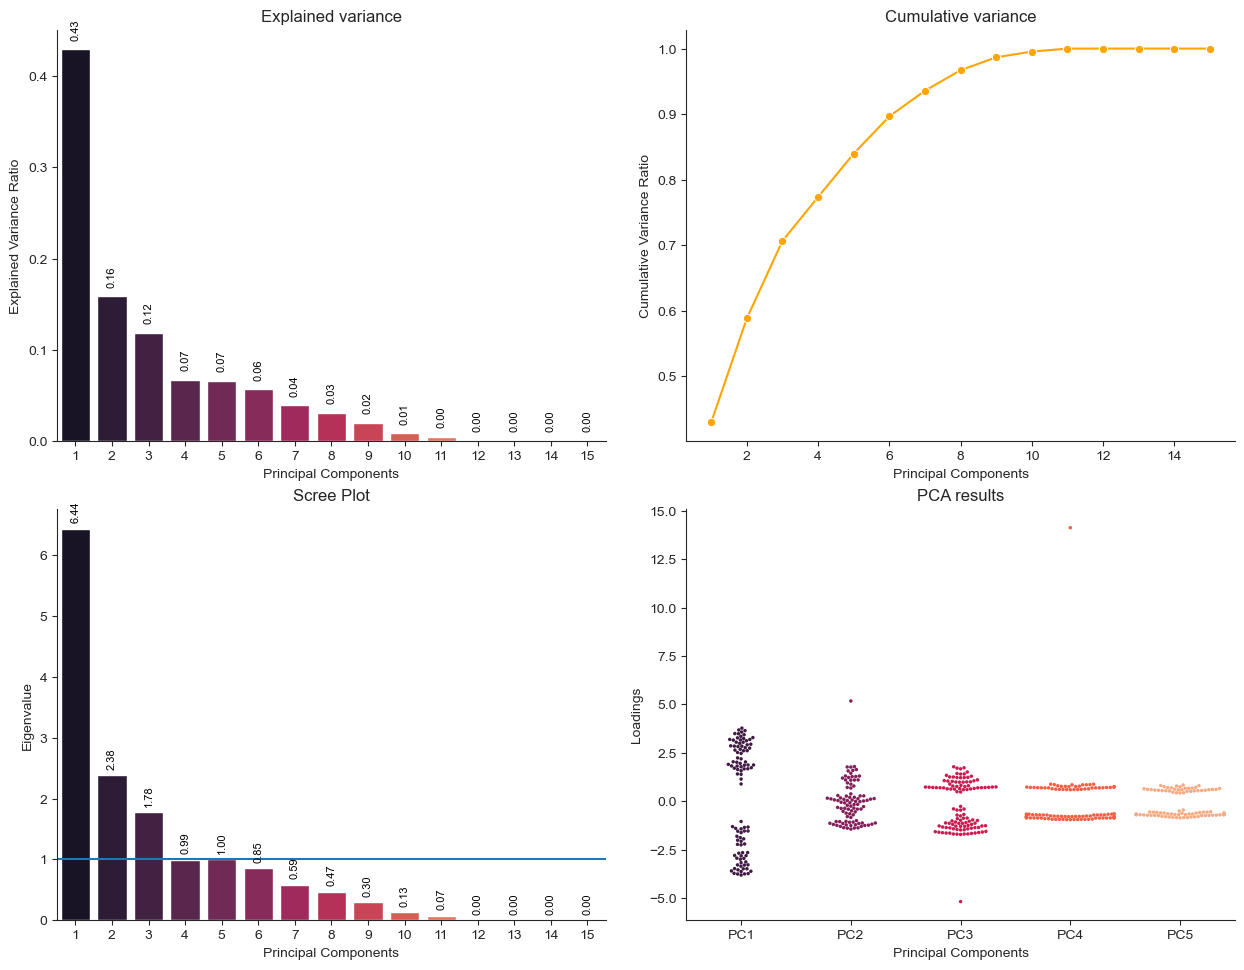

<Figure size 640x480 with 0 Axes>

In [52]:
''' Visualizing data analysis results '''
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

sns.set_style("ticks")
sns.color_palette("rocket_r", as_cmap=True)
f, axs = plt.subplots(2, 2, figsize=(13, 10), gridspec_kw=dict(width_ratios=[5, 5]))
f.tight_layout(pad=3.0)

''' Explained variance '''
explained_variance = pca.explained_variance_ratio_
variance_data = pd.DataFrame({'Principle Components':range(1, len(explained_variance) + 1),
                              'Variance':explained_variance})

# Plot explained variance
ax_variance = sns.barplot(
    data=variance_data,
    x='Principle Components',
    y='Variance',
    #hue='Variance',
    palette='rocket',
    dodge=False,
    ax=axs[0][0]
)
axs[0][0].set_title("Explained variance", fontsize=12)
axs[0][0].set_xlabel('Principal Components', fontsize=10)
axs[0][0].set_ylabel('Explained Variance Ratio', fontsize=10)
#ax_variance.legend_.remove()

padding = 0.01
for index, row in variance_data.iterrows():
    ax_variance.text(row.name, row.Variance + padding, f'{row.Variance:.2f}', color='black', ha="center", va="bottom",rotation=90, fontsize=8)


''' Cumulative variance '''
cumulative_variance = np.cumsum(explained_variance)

# Plot cumulative variance
sns.lineplot(x=np.arange(1, len(cumulative_variance) + 1), y=cumulative_variance, marker='o', color='orange',ax=axs[0][1])
axs[0][1].set_title("Cumulative variance", fontsize=12)
axs[0][1].set_xlabel('Principal Components', fontsize=10)
axs[0][1].set_ylabel('Cumulative Variance Ratio', fontsize=10)

''' Scree plot '''
# Compute the covariance matrix 
cov_matrix_original = np.cov(X_pca.T) # Compute the covariance matrix
eigenvalues_original, _ = np.linalg.eig(cov_matrix_original) # Compute the eigenvalues of the covariance matrix
scree_data = pd.DataFrame({'Principal Components': range(1, len(eigenvalues_original) + 1),
                           'Eigenvalue': eigenvalues_original})

ax = sns.barplot(
    data=scree_data,
    x='Principal Components',
    y='Eigenvalue',
    #hue='Eigenvalue',
    palette='rocket',
    dodge=False,
    ax=axs[1][0]
)
axs[1][0].axhline(y=1) # cutoff line 
axs[1][0].set_title("Scree Plot", fontsize=12)
axs[1][0].set_xlabel('Principal Components', fontsize=10)
axs[1][0].set_ylabel('Eigenvalue', fontsize=10)
#ax.legend_.remove()

padding = 0.1
for index, row in scree_data.iterrows():
    ax.text(row.name, row.Eigenvalue + padding, f'{row.Eigenvalue:.2f}', color='black', ha="center", va="bottom",rotation=90, fontsize=8)

''' PCA results '''
sns.swarmplot(
    data=pca_df_melt_sample, # should only show first 5 components 
    x="PC",
    y="loadings",
    hue='PC',
    size=2.5,
    legend=False,
    palette='rocket',
    ax=axs[1][1]
)
axs[1][1].set_title("PCA results", fontsize=12)
axs[1][1].set_xlabel('Principal Components', fontsize=10)
axs[1][1].set_ylabel('Loadings', fontsize=10)
sns.despine()

plt.show()
plt.savefig('training_data_feature_analysis.png')


## Generating training data based upon principle component loadings 

In [53]:
# Get the principal component loadings
pc_loadings = pca.components_
loadings_df = pd.DataFrame(pc_loadings, columns=X.columns) # Create a DataFrame to store the loadings along with their corresponding column names
print(loadings_df)


       first       bwt         $         A         C         G         T  \
0   0.378631 -0.003245  0.032852  0.386513  0.386268  0.386346  0.386135   
1  -0.021731 -0.002896 -0.004479 -0.033566 -0.033519 -0.033743 -0.033727   
2  -0.018600  0.003126  0.007367 -0.026833 -0.026998 -0.026996 -0.027047   
3  -0.015791  0.777975  0.625619  0.003729  0.004930  0.003781  0.004006   
4  -0.029847 -0.626475  0.766864  0.015639  0.017279  0.015080  0.015663   
5  -0.026448 -0.044418  0.128277 -0.102156 -0.102418 -0.102692 -0.103190   
6  -0.007983 -0.010783 -0.012380  0.008124  0.008528  0.008509  0.008452   
7  -0.024300 -0.003285  0.016145  0.030179  0.030541  0.030627  0.031075   
8   0.453751 -0.011750  0.049593 -0.283752 -0.289662 -0.287515 -0.292899   
9  -0.266962  0.004067 -0.005882  0.057401  0.060301  0.058550  0.061042   
10  0.196598 -0.000769 -0.000358 -0.017654 -0.019148 -0.018938 -0.019993   
11 -0.058391  0.000399 -0.001615  0.290528  0.641760 -0.644254 -0.287160   
12  0.169126

In [54]:
loadings_df.to_csv('pca_loadings.csv', index=False)

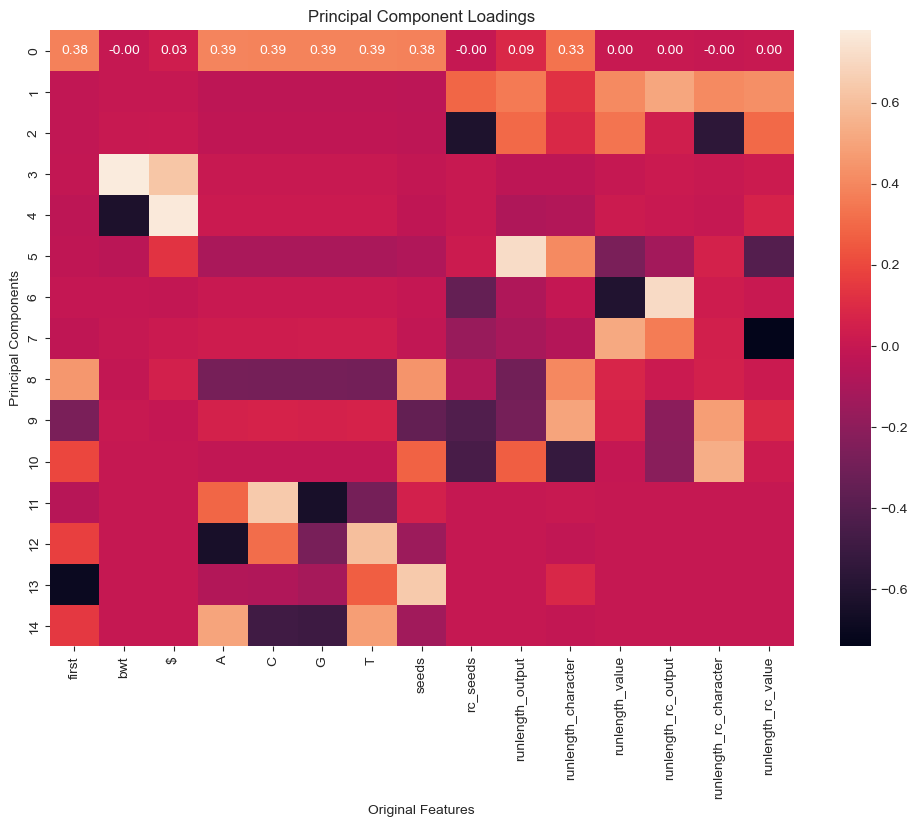

In [56]:
# Plot the principal component loadings as a heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(loadings_df, cmap='rocket', annot=True, fmt=".2f")
plt.title('Principal Component Loadings')
plt.xlabel('Original Features')
plt.ylabel('Principal Components')
plt.show()

In [60]:
""" Final output training and test dataset """

df_training_data = pd.DataFrame({
    "first":first_char,
    "A":df_var_complete['A'],
    "C":df_var_complete['C'],
    "G":df_var_complete['G'],
    "T":df_var_complete['T'],
    "seeds":seeds_encoded,
    "rc_seeds":rc_seeds_encoded,
    "runlength_output":runlength_output_encoded,
    "runlength_value":df_var_complete['runlength_value'],
    "runlength_rc_output":runlength_rc_output_encoded,
    "runlength_rc_character":runlength_rc_character_encoded,
    "runlength_rc_value":df_var_complete['runlength_rc_value'],
    "org_location":df_var_complete['org_location'],
})

df_training_data.to_csv('df_training_data.csv', index = False)

# Model Selection

In [ ]:
""" Experimental setup """